# Solution of the radial Schrödinger equation by mapped Fourier transform algorithms
Following 
[A. G. Borisov, J. Chem. Phys. 114, 7770–7777 (2001)](https://doi.org/10.1063/1.1358867)

The radial Schrödinger equation in cylindrical coordinates is:
\begin{equation}
  \left(-\frac{1}{2} \frac{1}{r} \frac{\partial}{\partial r} r \frac{\partial}{\partial r} + \frac{j^2}{2r^2} + V \right)\Psi = E\Psi
\end{equation}
where $r$ is the radial coordinate, $j=\frac{\partial}{\partial \theta}$ is the magnetic quantum number and $V$ is the potential. Scaling the wave function as $\Psi = \tilde{\Psi} / \sqrt{r}$ yields the usual equation:
\begin{equation}
  \left(-\frac{1}{2} \frac{\partial^2}{\partial r^2} + \frac{j^2 - 1/4}{2r^2} + V \right)\tilde{\Psi} = E\tilde{\Psi}
\end{equation}
Borisov, however, sugests a more general mapping:
\begin{align}
  r &= f(x) \\
  J &= df/dx \\
  \Psi &= \Phi / \sqrt{fJ}
\end{align}
which yields the following equation, our object of study:
\begin{equation}
  \boxed{
    \left(
      -\frac{1}{2} \frac{1}{\sqrt{fJ}} \frac{\partial}{\partial x} \frac{f}{J} \frac{\partial}{\partial x} \frac{1}{\sqrt{fJ}}
      + \frac{j^2}{2f^2} + V
    \right)\Phi = E\Phi
  }
\end{equation}



In [1]:
# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

import numpy as np
from functools import partial
np.set_printoptions(linewidth=np.inf)

# data types and number of points to use
dtype = np.float64
N = 512

Discrete cosine and sine transforms of the 2nd type are used to switch between coordinate and momentum space (c.f. Press et al. - *Numerical Recipes*, 3rd Ed. section 12.4.2). I build them explicitly here following eqations 5 and 6; Once we have everything working, we can look into using an FFT.

\begin{align}
  {\left(\mathbf{A}_{\cos}\right)}_{km} &= \cos\left(\frac{2m-1}{2N} k\pi \right) \\
  {\left(\mathbf{A}_{\sin}\right)}_{km} &= \sin\left(\frac{2m-1}{2N} k\pi\right)
\end{align}
Note that while $m$ runs over $1 \ldots N$, $k$ runs over $0 \ldots N$ and thus $\mathbf{A}_{\cos}$ and $\mathbf{A}_{\sin}$ are of dimension $N+1 \times N$. With these definitions, we can rewrite 5a--6b as follows:
\begin{align}
  C_k &= \alpha(k) F \mathbf{A}_{\cos} \\
  F_m &= \frac{2}{N} \sum_{k=0}^{N-1} \alpha(k) C_k {\left(\mathbf{A}_{\cos}\right)}_{km} \\
  S_k &= \alpha(k) F \mathbf{A}_{\sin} \\
  F_m &= \frac{2}{N} \sum_{k=1}^{N} \alpha(k) C_k {\left(\mathbf{A}_{\sin}\right)}_{km}
\end{align}
Where the forward transforms (a) are written as simple matrix vector products. The inverse transforms (b) have similar analogues; see the implementation below.


In [2]:
# returns integers on [a,b], inclusive of both endpoints
def bound(a,b):
    return np.array(range(a,b+1))
assert(all(bound(1,4) == [1,2,3,4]))

# alpha term in equation 5-7;
# R.B.: simply applying np.vectorize to a lambda may have unexpected (wrong) results!
al = lambda k: np.where((k == 0) | (k == N), 1/np.sqrt(2), 1)

# Helper function to pre-compute sine and cosine matrices (Asin & Acos above)
def DTT(N, func):
    k = bound(0, N)
    m = bound(1, N)
    return func(np.outer(2*m-1,k) * np.pi/N/2)

COS = DTT(N, np.cos)
SIN = DTT(N, np.sin)

def Ac(F):
    k = bound(0,N)
    return F @ COS * al(k)

def Acv(C):
    k = bound(0,N-1)
    Ck = C[k] if C.ndim == 1 else C[:, k]
    return (2/N) * al(k) * Ck @ COS.T[k]

def As(F):
    k = bound(0,N)
    return F @ SIN * al(k)

def Asv(S):
    k = bound(1,N)
    Sk = S[k] if S.ndim == 1 else S[:, k]
    return (2/N) * al(k) * Sk @ SIN.T[k]

# explicit forms of 5--6 for comparisson; no need to read these as long as the asserts succeed
def Ac2(F):
    C = np.zeros(N+1)
    m = bound(1,N)
    for k in bound(0,N):
        C[k] = al(k) * np.sum(F*np.cos((2*m-1)*k*np.pi/N/2))
    return C

def Acv2(C):
    F = np.zeros(N)
    k = bound(0,N-1)
    for m in bound(1,N):
        F[m-1] = 2/N * np.sum((al(k)*C[k]*np.cos((2*m-1)*k*np.pi/N/2)))
    return F

def As2(F):
    S = np.zeros(N+1)
    m = bound(1,N)
    for k in bound(0,N):
        S[k] = al(k) * np.sum(F * np.sin((2*m-1)*k*np.pi/N/2))
    return S

def Asv2(S):
    F = np.zeros(N)
    k = bound(1, N)
    for m in bound(1,N):
        F[m-1] = 2/N * np.sum((al(k)*S[k]*np.sin((2*m-1)*k*np.pi/N/2)))
    return F

# Do the matrix forms match the explicit forms?
v = np.random.random(N)
u = np.random.random(N)
assert(np.allclose(As(v), As2(v)))
assert(np.allclose(Ac(v), Ac2(v)))
# work batching too?
assert(np.allclose(Ac(np.vstack([v,u])), np.vstack([Ac2(v),Ac2(u)])))
assert(np.allclose(As(np.vstack([v,u])), np.vstack([As2(v),As2(u)])))

# Do the matrix forms of the inverses match the explicit forms?
v = np.random.random(N+1)
u = np.random.random(N+1)
assert(np.allclose(Asv(v), Asv2(v)))
assert(np.allclose(Acv(v), Acv2(v)))
# work batching too?
assert(np.allclose(Acv(np.vstack([v,u])), np.vstack([Acv2(v),Acv2(u)])))
assert(np.allclose(Asv(np.vstack([v,u])), np.vstack([Asv2(v),Asv2(u)])))

The adaptive grid is defined as follows, c.f. eqn. 15:
\begin{equation}
\Delta (r) = \frac{\Delta }{f'(r)} = \frac{\alpha \pi}{\sqrt{2 (W-U(r))}}
\end{equation}
Then the mapped grid points are determined by $x_i = f(R_i)$ via the integration

\begin{equation}
    x_i = f(R_i) = \int_0^{R_i} \frac{dr \Delta }{\Delta(r)}
\end{equation}
Where we accept the fact that Borisov has given a complete bloody abuse of notation by using the variable $\Delta$ to mean two different things. $\Delta$ the constant refers to the exentual constant grid spacing between the $x_i$-- TAKEN AS AN INPUT VARIABLE like alpha which I think makes them interchangable-- whereas $\Delta(r)$ could have just been named some other name like $s(r)$ as it is named in the previous Kosloff papers. So when it says we want to take a gauss filter of width $\pi/8\Delta$ I am quite sure he means $\pi/8\alpha$...

Recall that $\alpha$ sets a density of points, $W$ sets an energy scale, and $U(r)$ (seems to) include all the diverging terms in the Hamiltonian.
\begin{align}
U(r) = -\frac{1}{8}\frac{1}{(r+\epsilon)^2}
\end{align}
Of note: Borisov takes $\epsilon = 10^{-20}$, but unless we take a much larger value (order $10^{-4}$) our results are numerically unstable.

We use a the forward Euler method (RK1) to integrate the above stepwise:
\begin{align}
r_0 &= \Delta(0) \\
r_i &= r_{i-1} + \Delta(r_{i-1})
\end{align}
And adjust $\alpha$ until the desired number of points, $N$,  for $r \in (0, r_{\textrm{max}}]$ is obtained.

In [12]:
r_max = 50
W = 2*N

# my inclination was use machine precision for the choosen datatype for eps,
# but that's waaay too small; I'm not sure why.
eps = 1e9*np.finfo(dtype).eps

# Generating function for the Harmonic Oscillator
U  = lambda r, eps=eps : (-1/8)/(r+eps)**2                         # equation 16
dr = lambda r, alpha, W=W : alpha * np.pi / np.sqrt(2*(W - U(r)))  # equation 15
# dr = lambda r, alpha, W=W : np.sqrt(2*(W - U(r)))/(np.pi*alpha)  # equation 15

def build_grid(N, r_max, alpha=1):
    def kernel(r_max, alpha):
        dr_ = partial(dr, alpha=alpha)
        r_grid = [dr_(1e-6)]
        while (ri := r_grid[-1]) < r_max:
            r_grid.append(ri + dr_(ri)) # bullshit, first-order integrator
        return np.array(r_grid, dtype=dtype)
        
    alpha = 0.7 # a guess
    r = kernel(r_max, alpha)
    niter = 1
    while r.size != N:
        alpha *= r.size / N
        r = kernel(r_max, alpha)
        
        niter += 1
        if niter > 100:
            raise RuntimeError("Unable to build grid")
    return r, alpha, niter

r, alpha, niter = build_grid(N, r_max)
print("ϵ =", eps)
print("ɑ =", alpha)
print("W =", W)

J = dr(r, alpha, W)

print(r.size, "points, spanning", f"{r[0]:.4} -- {r[-1]:.4}", f"built in {niter} iteration(s)")
print

ϵ = 2.220446049250313e-07
ɑ = 1.4205665588378906
W = 1024
512 points, spanning 1.091e-05 -- 50.08 built in 3 iteration(s)


<function print>

(512,)
(513,)


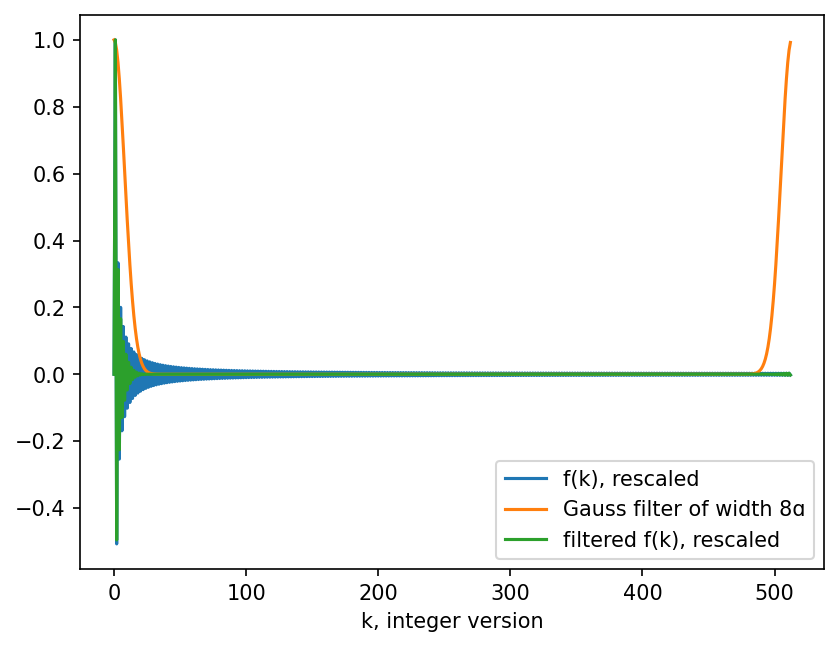

In [4]:
print(r.shape)
fk = As2(r)
print(fk.shape)
width = 8*alpha
gau = [np.exp(-min(k, N+1-k)**2/width**2) for k in range(N+1)]
plt.plot(range(N+1),fk/np.max(np.abs(fk)), label="f(k), rescaled")
plt.plot(range(N+1), gau, label="Gauss filter of width 8ɑ")
fk = fk*gau
plt.plot(range(N+1),fk/np.max(np.abs(fk)), label="filtered f(k), rescaled")
plt.legend()
plt.xlabel("k, integer version")
# print(gau)
r_new = Asv2(fk)

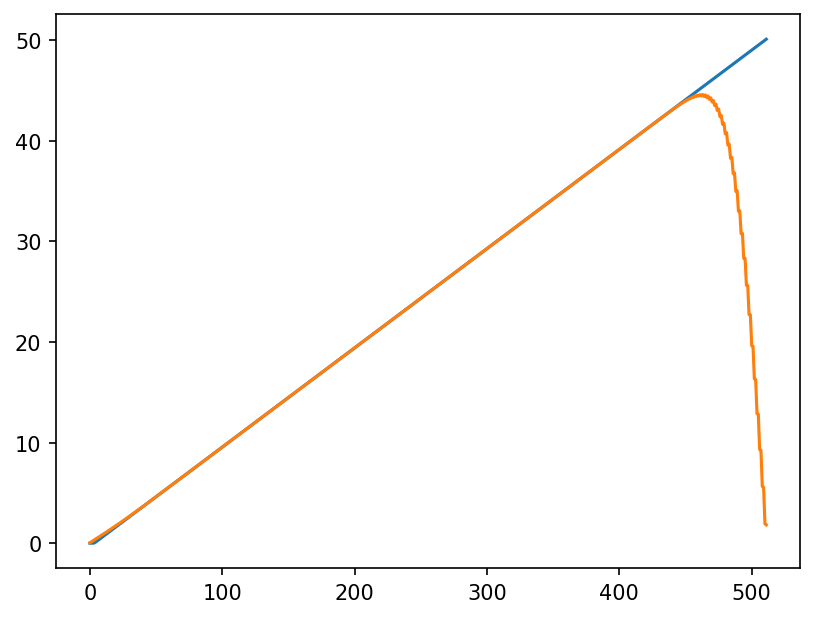

In [5]:
# plt.plot(range(N), np.log(r))
# plt.plot(range(N), np.log(r_new))
plt.plot(range(N), r)
plt.plot(range(N), r_new)

Now we're ready to build $L$; note that we use a trivially different definition of $L$ from that given in the paper such that:
\begin{equation}
  H = -\frac{L}{2} + \frac{j^2}{2f^2} + V
\end{equation}
$L$ is therfore given by:
\begin{align}
L = \frac{1}{\sqrt{fJ}} \frac{\partial}{\partial x} \frac{f}{J} \frac{\partial}{\partial x} \frac{1}{\sqrt{fJ}}
\end{align}
And equations 11--13 can be used to express $L$ in our choosen basis.

In [6]:
F = np.copy(r)
B = np.diag(1/np.sqrt(F*J))
R = np.diag(F/J)
K = np.diag(range(N+1)) * np.pi / r_max

l_func = lambda xi: B @ Acv(K @ As(R @ Asv(K @ Ac(B @ xi))))
L = -np.array([l_func(xi) for xi in np.eye(N)])

# I'd like to be able to use the batching forms of Ac etc and do something like this, but no dice
#assert(np.allclose(
#    L,
#    B@Acv((K@As(R@Asv((K@(Ac(B @ np.eye(N))).T).T)).T).T)
#))

deviation = np.mean(np.abs(L-L.T))
print("Mean deviation from Hermiticity:", deviation)
if deviation < 1e-5:
    L = (L + L.T)/2
    print("symmetrizing L yielded:", np.mean(np.abs(L-L.T)))
else:
    raise RuntimeError("Deviation too large!")


Mean deviation from Hermiticity: 6.118735406792707e-11
symmetrizing L yielded: 0.0


[1.         3.00000006 5.00000048 7.00000108 9.00000178]


Text(0.5, 0, '$r$')

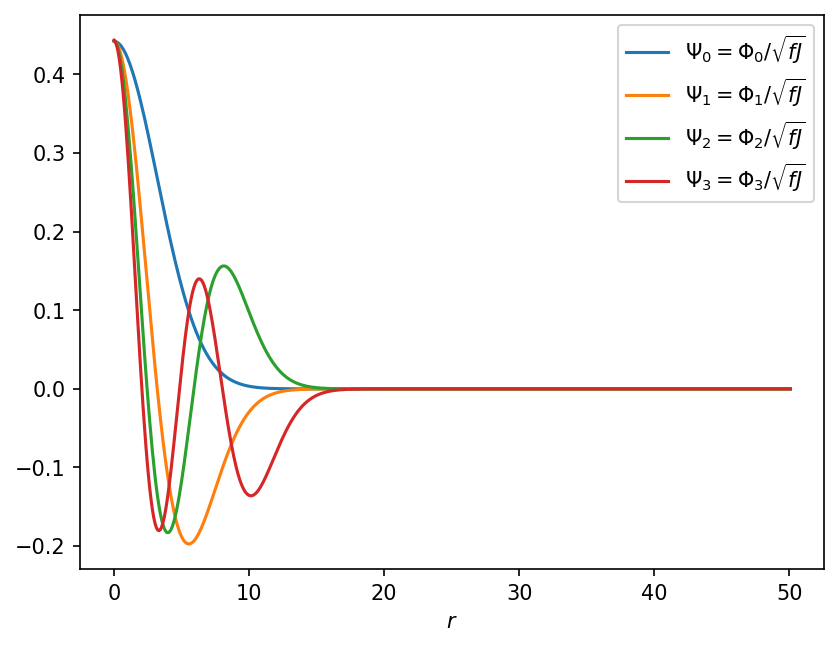

In [7]:
j = 0
V = r**2/2
H = -L/2 + np.diag(j**2/(2*r**2)) + np.diag(V)
en, psi = np.linalg.eigh(H)
psi = psi.T
# match phases
for i,p in enumerate(psi):
    if p[0] < 0:
        psi[i] *= -1
print(en[:5]/en[0])

fig, ax = plt.subplots()
#ax.plot(r, psi[0]**2, '-o')

for i in range(4):
    line, = ax.plot(r, psi[i]/np.sqrt(F*J), label=rf'$\Psi_{{{i}}}=\Phi_{{{i}}}/\sqrt{{fJ}}$')
    # uncomment to include reflected part
    #ax.plot(-r, psi[i]/np.sqrt(F*J), color=line.get_color())
ax.legend(loc='best')
ax.set_xlabel('$r$')

Converged for n < 49, for threshold 1e-05.


/var/folders/8c/vngv9xgx14j8h3mv6ysbf8z00000gn/T/ipykernel_4506/1418485561.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(N), np.log(error)/np.log(10))


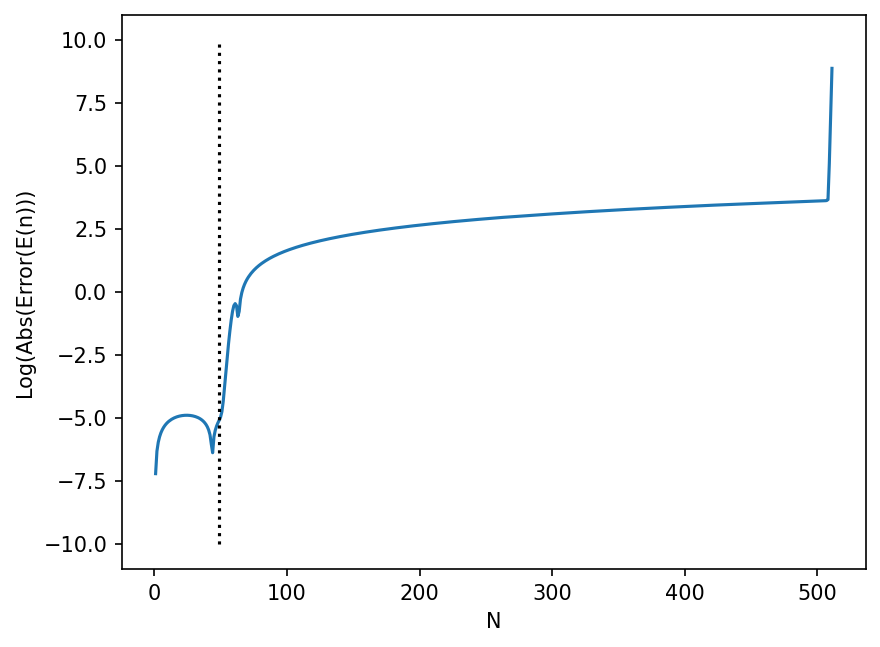

In [8]:

error = np.abs(en/en[0]-np.arange(1,2*N,2))
plt.plot(range(N), np.log(error)/np.log(10))
plt.xlabel("N")
plt.ylabel("Log(Abs(Error(E(n)))")
thresh = 1e-5
max_conv = np.max(np.argwhere(error <= thresh))
print("Converged for n < {}, for threshold {}.".format(max_conv,thresh))
plt.vlines(x=max_conv, ymin=-10, ymax= 10, color='k', linestyle=":")

## Current issues

These Wavefunctions and energies look plausible; hooray! *But*, they are not scale invariant, which is clearly wrong! Try playing with the number of points $N$ (at the top) or $r_{\max}$ (above). Hopefully the error results from a small problem, but I don't know how to fix it yet!

Another issue is that the value of $\epsilon$ has to be much larger than given in the text. I suspect that I'm missing something about the integration of equation 15 for $f$. That might also impact the scale issues mentioned above.

Perhaps related: I have not applied the "Gauss filter" of width $\pi/8\Delta$ in momentum space (c.f. the discussion below eq 15) since I don't actually know what $\Delta$ is! Perhaps that ignorance and the want of smoothing are the sources of all my troubles.

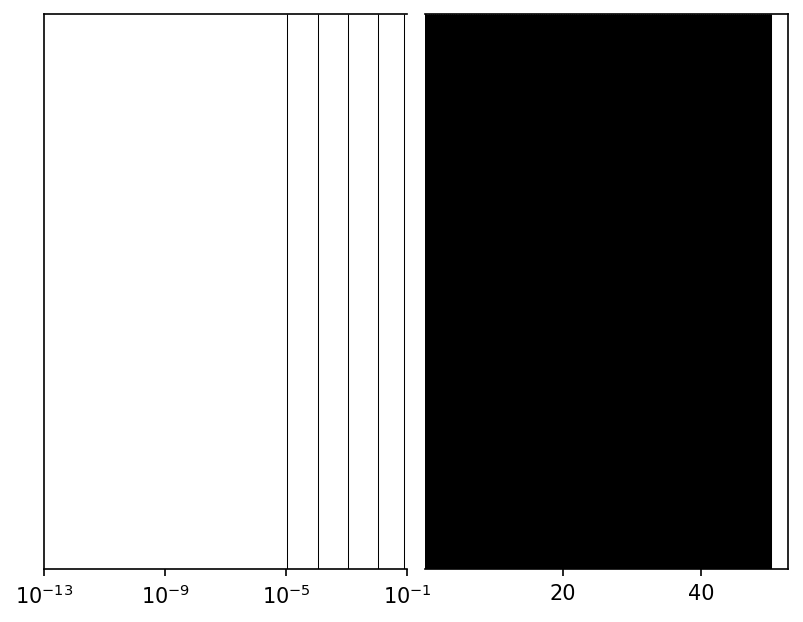

In [9]:
fig, [ax_log, ax_lin] = plt.subplots(1,2, sharey=True)

divide = 1e-1
for ax in [ax_log, ax_lin]:
    ax.vlines(r, 0, 1, color='k', lw=0.5)
    ax.set_ylim(0,1)
    #ax.vlines([divide], 0, 1, color='r', ls=':', lw=0.5)
    ax.set_yticks([])
ax_log.set_xscale('log')
ax_log.set_xlim(right=divide)
ax_lin.set_xlim( left=divide)
ax_log.spines['right'].set_visible(False)
ax_lin.spines['left' ].set_visible(False)
ax_log.set_xticks([1e-13,1e-9,1e-5,1e-1])
ax_lin.yaxis.tick_right()
fig.subplots_adjust(wspace=0.05)

In [10]:
from scipy.integrate import solve_ivp
soln = solve_ivp(lambda _, x: dr(x, alpha=alpha), (0, r_max*100), [0], dense_output=True)
print(soln)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  6.419e+02  5.000e+03]
        y: [[ 0.000e+00  1.983e-10 ...  6.319e+01  4.930e+02]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x1108d8340>
 t_events: None
 y_events: None
     nfev: 104
     njev: 0
      nlu: 0


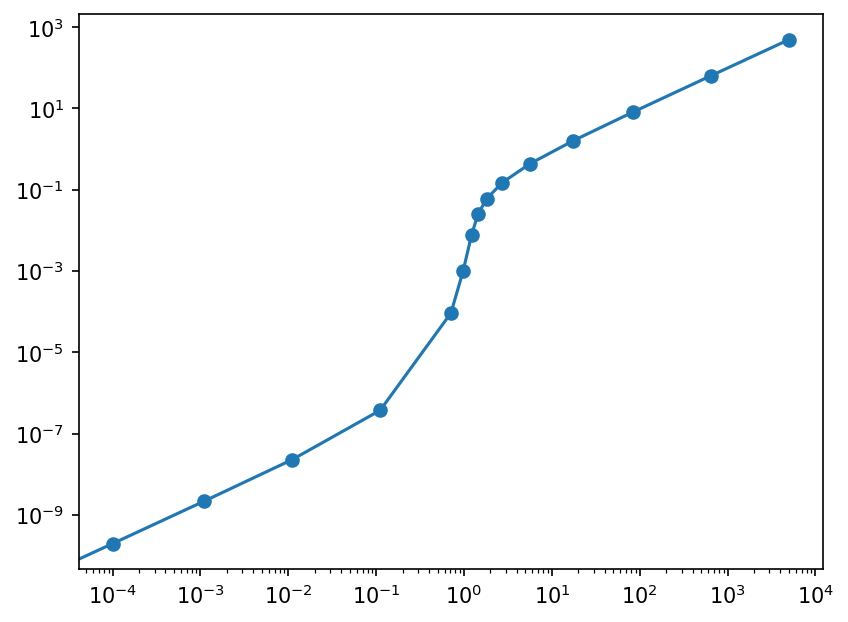

In [11]:
fig, ax = plt.subplots()
#ax.plot(r,soln.sol(r).squeeze(), '-o')
ax.plot(soln.t,soln.y.squeeze(), '-o')

ax.set_yscale('log')
ax.set_xscale('log')